# PCR and PLS Regression

In [1]:
# import modules
import pandas as pd
import numpy as np

from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import itertools
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# load the data
df = pd.read_csv('./datasets/Hitters.csv').dropna().drop('Unnamed: 0', axis=1)
df = pd.get_dummies(df,columns=['League', 'Division', 'NewLeague'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 23 columns):
AtBat          263 non-null int64
Hits           263 non-null int64
HmRun          263 non-null int64
Runs           263 non-null int64
RBI            263 non-null int64
Walks          263 non-null int64
Years          263 non-null int64
CAtBat         263 non-null int64
CHits          263 non-null int64
CHmRun         263 non-null int64
CRuns          263 non-null int64
CRBI           263 non-null int64
CWalks         263 non-null int64
PutOuts        263 non-null int64
Assists        263 non-null int64
Errors         263 non-null int64
Salary         263 non-null float64
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(1), int64(16), uint8(6)
memory usage: 38.5 KB


In [3]:
# prepare variables
y = df['Salary']
X = df[df.columns.difference(['Salary'])]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 22 columns):
Assists        263 non-null int64
AtBat          263 non-null int64
CAtBat         263 non-null int64
CHits          263 non-null int64
CHmRun         263 non-null int64
CRBI           263 non-null int64
CRuns          263 non-null int64
CWalks         263 non-null int64
Division_E     263 non-null uint8
Division_W     263 non-null uint8
Errors         263 non-null int64
Hits           263 non-null int64
HmRun          263 non-null int64
League_A       263 non-null uint8
League_N       263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
PutOuts        263 non-null int64
RBI            263 non-null int64
Runs           263 non-null int64
Walks          263 non-null int64
Years          263 non-null int64
dtypes: int64(16), uint8(6)
memory usage: 36.5 KB


# 1. PCR Regression

In [15]:
# create PCA and reduce the dataset
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(263, 22)

In [16]:
# 10-fold cv
n = len(X_reduced)
kf_10 = cross_validation.KFold(n=n,n_folds=10,random_state=1)

# fit a linear regression on the data
regr = LinearRegression()

# store mse
mse = []

# compute MSE without feature (only intercept)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10,
                                            scoring='mean_squared_error').mean() 
mse.append(score)

# compte MSE for models made of 1 to 22 features
for i in range(1,23):
    score = -1 * cross_validation.cross_val_score(regr, X_reduced[:,:i],y,cv=kf_10,
                                                 scoring='mean_squared_error').mean()
    mse.append(score)

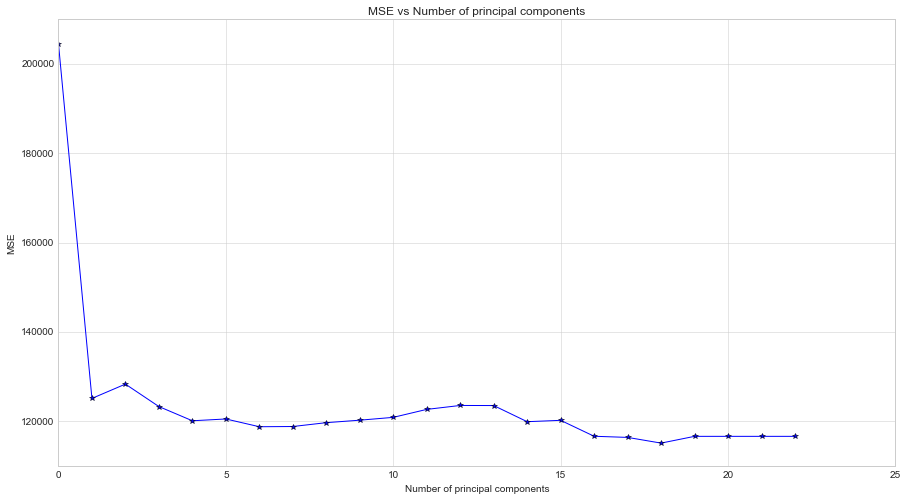

In [18]:
# plot
fig = plt.figure(figsize=(15,8))
plt.plot(mse,'-*')
plt.title('MSE vs Number of principal components')
plt.xlabel('Number of principal components')
plt.ylabel('MSE');

As shown above, there is no clear imporvements between a model containing only a few features vs. a complete model.

In [19]:
# perform evaluation using a test set
pca2 = PCA()

# Split into training and test sets# Split  
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

# store mse
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)

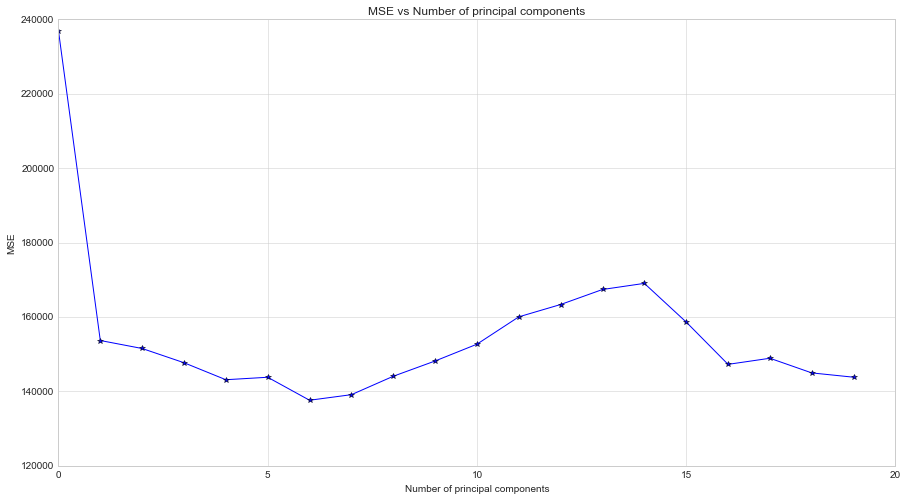

In [20]:
# plot
fig = plt.figure(figsize=(15,8))
plt.plot(mse,'-*')
plt.title('MSE vs Number of principal components')
plt.xlabel('Number of principal components')
plt.ylabel('MSE');

In [23]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111456.9462755303

# 2. Partial Least Squares

In [32]:
# 10-fold cv
n = len(X_train)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

# store mse
mse = []

# compute MSE without feature (only intercept)
for i in range(1,20):
    pls = PLSRegression(n_components=i)
    score = cross_validation.cross_val_score(pls, scale(X_train), y_train, cv=kf_10,
                                             scoring='mean_squared_error').mean()
    mse.append(-score)

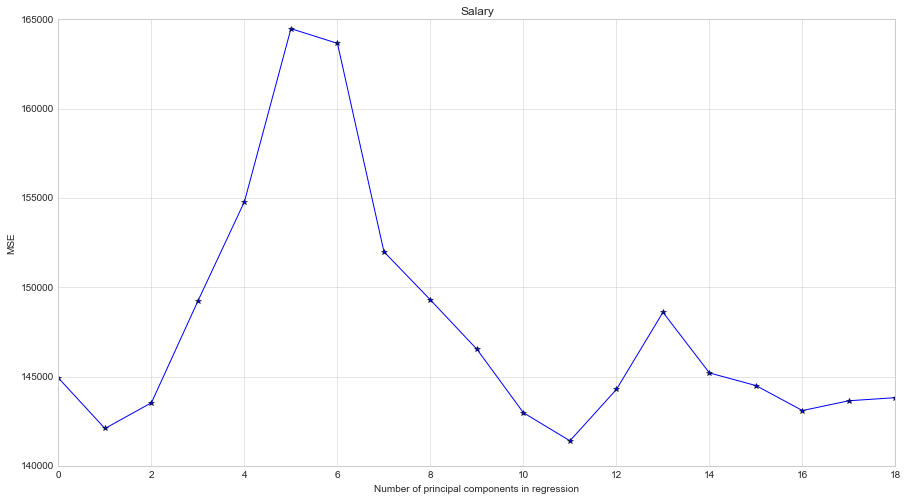

In [36]:
# Plot results
fig = plt.figure(figsize=(15,8))
plt.plot(mse,'-*')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary');